In [11]:
# Import modules
import pandas as pd
import numpy as np
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from pandas.api.types import is_numeric_dtype
from IPython.display import HTML
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner as kt
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.metrics import Precision, Recall

%matplotlib inline

In [4]:
# Dataset
dataset = pd.read_csv('FullDatawithOutcome.csv')
df=dataset.dropna(axis=0)
df_full=df.reset_index(drop=True)

In [5]:
# Check dataset shape
print('Full Dataset:',df_full.shape)

Full Dataset: (19809, 157)


In [6]:
FeatureList = ['ADI_NATRANK',
 'adi_staterank',
 'ca_hpi_score',
 'ambEng_count_cardiologist_visit_24M',
 'ambEng_count_lag_12m_md_touch',
 'ambEng_count_lag_12m_non_md_touch',
 'ambEng_count_lag_12m_uniq_md_touch',
 'ambEng_count_lag_12m_uniq_non_md_touch',
 'count_lag_4q_ed_only_visits',
 'demographics_pat_age',
 'ef_low_score_codified',
 'is_ccw_conditions_count',
 'labs_last_creatinine_level_codified',
 'labs_last_glucose_level_codified',
 'medication_COUNT_ACTIVE_FILLED_MEDS',
 'priorUtil_Count_Attributed_Specialists',
 'priorUtil_count_lag_4q_admits',
 'priorUtil_exposure_proportion_6q',
 'ambEng_cardiologist_referral_ever',
 'ambEng_cardiologist_visit_ever',
 'ambEng_is_md_visit_6m',
 'ambEng_is_non_md_visit_6m',
 'ambEng_pulmonologist_visit_ever',
 'demographics_HealthCoverage_Medicare',
 'demographics_Managed_Care_CMS_MSSP',
 'is_ccw_anemia',
 'is_ccw_ckd',
 'is_ccw_copd',
 'is_ccw_diabetes',
 'is_ccw_heart_failure',
 'is_ccw_htn',
 'is_ccw_hyperlipidemia',
 'is_ccw_ischemic_heart_disease',
 'is_ccw_ra_oa',
 'is_fpg_high_risk',
 'is_fpg_highest_risk',
 'medication_Bronchodilator_SABA',
 'priorUtil_is_zero_admn_or_ed_visit_pr_yr',
 'priorUtil_UCD_MVP']

In [7]:
# Data Prep
#scale data

ss = StandardScaler()

X = pd.DataFrame(ss.fit_transform(df_full[FeatureList],), columns = FeatureList)
y=df_full["FINAL_OUTCOME"]

# Create training and testing database
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X, y, test_size=0.2, random_state=2345)

print('X_train_A: ',X_train_A.shape)
print('y_train_A: ',y_train_A.shape)
# y_train.shape

X_train_A:  (15847, 39)
y_train_A:  (15847,)


In [9]:
# Create a method that creates a new Sequential model with hyperparameter options


def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=39))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    # nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    #nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['Precision', 'Recall'])
    nn_model.compile(loss="binary_crossentropy",optimizer='adam',metrics=[Precision(), Recall()])


    return nn_model

In [12]:
# Import the kerastuner library


import shutil
shutil.rmtree('untitled_project', ignore_errors=True)

# tuner = kt.Hyperband(
#     create_model,
#     objective="val_accuracy",
#     max_epochs=20,
#     hyperband_iterations=2)

tuner = kt.Hyperband(
    create_model,
    objective='val_precision',
    max_epochs=60,
    hyperband_iterations=2)

In [13]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_A,y_train_A,epochs=20,validation_data=(X_test_A,y_test_A))

Trial 180 Complete [00h 02m 35s]
val_precision: 0.0

Best val_precision So Far: 1.0
Total elapsed time: 03h 46m 33s


In [14]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 9,
 'num_layers': 4,
 'units_0': 5,
 'units_1': 1,
 'units_2': 7,
 'units_3': 1,
 'units_4': 9,
 'units_5': 7,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [18]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
# model_loss, model_accuracy = best_model.evaluate(X_test_A,y_test_A,verbose=2)
model_loss, model_precision, model_recall = best_model.evaluate(X_test_A, y_test_A, verbose=2)
print(f"Loss: {model_loss}, Precision: {model_precision}, Recall: {model_recall}")

C:\Users\19163\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\19163\anaconda3\envs\dev\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


124/124 - 1s - 5ms/step - loss: 0.1596 - precision: 1.0000 - recall: 0.0325
Loss: 0.15957634150981903, Precision: 1.0, Recall: 0.03246753290295601


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


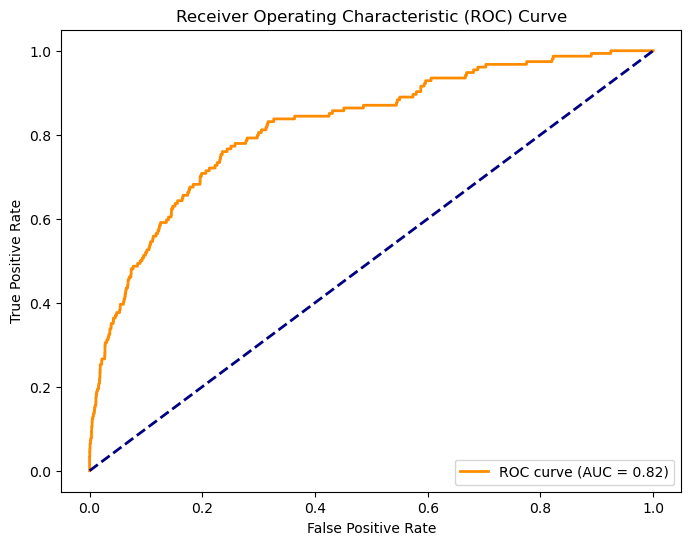

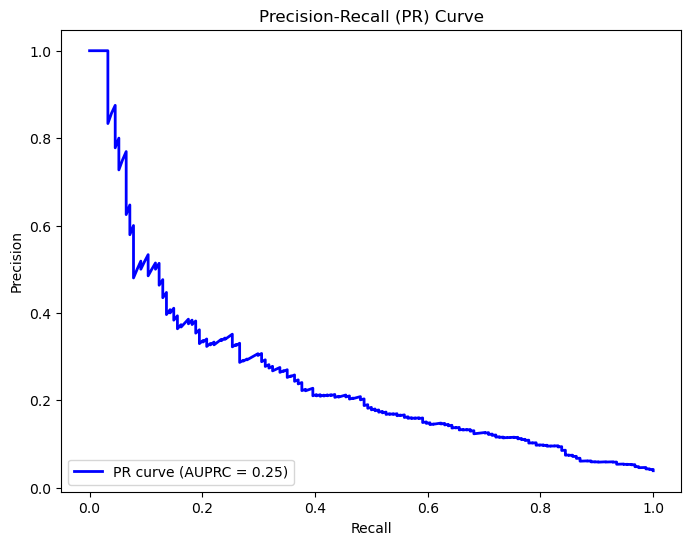

In [19]:
# 1️⃣ Get predicted probabilities
y_pred_prob = best_model.predict(X_test_A).ravel()  # flatten to 1D array if needed

# 2️⃣ ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test_A, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 3️⃣ Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test_A, y_pred_prob)
average_precision = average_precision_score(y_test_A, y_pred_prob)
auprc = auc(recall, precision)  # Notice: reverse axis order

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUPRC = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower left')
plt.show()


In [20]:
print(auprc)

0.2523697375807121
